In [133]:
import copy
import matplotlib.pyplot as plt
from moexalgo import Ticker
import numpy as np
import pandas as pd
from prophet import Prophet


def predict_price(ticker, date_start, date_end, period_forecast = 14, freq_train='1h', freq_forecast='D'):
    """
    Функция для предсказания цен акции в будущем

    ...
    
    Параметры
    ----------
    ticker : str
        название тикета, для которого нужно предсказать цены
    date_start : str
        дата начала периода, на котором обучаемся, в формате 'YYYY-MM-DD'
    date_end : str
        дата конца пероида, на котором обучаемся, в формате 'YYYY-MM-DD'
    period_forecast: int
        количество предсказаний (по умолчанию 31)
    freq_train: str
        периодичность данных, на которых обучаемся, в формате pandas (по умолчанию '1h', то есть часовая)
    freq_forecast: str
        частота, с которым нужно предсказывать цену в формате pandas (по умолчанию 'D')
        
    """
    
    data_train = Ticker(ticker).candles(date=date_start, till_date=date_end, period=freq_train)
    data_train = data_train[['close', 'end']].rename(columns = {'close': 'y', 'end': 'ds'})
    
    m = Prophet(weekly_seasonality=False,daily_seasonality=False,yearly_seasonality=False)
    m.fit(data_train)
    future = m.make_future_dataframe(period_forecast, freq=freq_forecast, include_history=False)
    fcst = m.predict(future)
                     
    return fcst

def uplift_metric(df_input):
    """
    Функция для расчёта метрики <(y_i - y_{i-1})/y_i> - <(y_hat_i - y_hat_{i-1})/y_hat_i>

    ...
    
    Параметры
    ----------
    df : pd.DataFrame
        DataFrame с полями ds - датой, y - реальной ценой акции, yhat - предсказанием цены
        
    """
    df = copy.deepcopy(df_input)
    df['y_delta'] =  df['y'].pct_change()
    df['yhat_delta'] =  df['yhat'].pct_change()
    
    df['y_delta_rel'] = df['y_delta']/df['y']
    df['yhat_delta_rel'] = df['yhat_delta']/df['yhat']
    
    metric = (df['y_delta_rel'].mean() - df['yhat_delta_rel'].mean())/df['y_delta_rel'].mean()
    return metric

def coeff(df_input):
    """
    Функция для расчёта метрики <(y_i - y_{i-1})/y_i> - <(y_hat_i - y_hat_{i-1})/y_hat_i>

    ...
    
    Параметры
    ----------
    df : pd.DataFrame
        DataFrame с полями ds - датой, y - реальной ценой акции, yhat - предсказанием цены
        
    """
    df = copy.deepcopy(df_input)
    df['y_delta'] =  df['y'].pct_change()
    df['yhat_delta'] =  df['yhat'].pct_change()
    
    df['y_delta_rel'] = df['y_delta']/df['y']
    df['yhat_delta_rel'] = df['yhat_delta']/df['yhat']

    return df['y_delta_rel'].mean(), df['yhat_delta_rel'].mean()


In [2]:
res = predict_price('SBER', '2022-01-01', '2023-10-01')
res.head()

19:46:40 - cmdstanpy - INFO - Chain [1] start processing
19:46:43 - cmdstanpy - INFO - Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-09-30 23:59:55,264.956265,251.534292,279.180856,264.956265,264.956265,0.0,0.0,0.0,0.0,0.0,0.0,264.956265
1,2023-10-01 23:59:55,265.160287,251.856350,278.681211,265.160287,265.160287,0.0,0.0,0.0,0.0,0.0,0.0,265.160287
2,2023-10-02 23:59:55,265.364309,252.566399,280.157809,265.364309,265.364309,0.0,0.0,0.0,0.0,0.0,0.0,265.364309
3,2023-10-03 23:59:55,265.568332,252.014678,279.362705,265.568332,265.568332,0.0,0.0,0.0,0.0,0.0,0.0,265.568332
4,2023-10-04 23:59:55,265.772354,253.086712,279.050230,265.772354,265.772354,0.0,0.0,0.0,0.0,0.0,0.0,265.772354


Из всего этого многообразия нас интересует пока что только `yhat`, (то бишь $\hat{y}$) дальше можно попробовать ещё данные отсюда.

In [3]:
res = res[['ds', 'yhat']]
#убираем время в датах, чтобы потом нормально джойнить с тестом
res['ds'] = res['ds'].dt.date

res.head()

,ds,yhat
0,2023-09-30,264.956265
1,2023-10-01,265.160287
2,2023-10-02,265.364309
3,2023-10-03,265.568332
4,2023-10-04,265.772354


Подгружаем данные для теста

In [8]:
df_test = Ticker('SBER').candles(date='2023-09-30', till_date='2023-11-02', period='D')
df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

df_test = df_test[['ds', 'y']]
df_test.head()

df_test['ds'] = df_test['ds'].dt.date
df_test.head()

res = res.merge(df_test, on='ds')
res.head()

,ds,yhat,y_x,y_y,y
0,2023-10-02,265.364309,258.98,258.98,258.98
1,2023-10-03,265.568332,259.65,259.65,259.65
2,2023-10-04,265.772354,259.53,259.53,259.53
3,2023-10-05,265.976377,259.38,259.38,259.38
4,2023-10-06,266.180399,262.93,262.93,262.93


Считаем метрики

In [9]:
res['diff'] = res['y'] - res['yhat']
rmse = np.sqrt(np.square(res['diff']).mean())
mae = np.abs(res['diff']).mean()
AVG = res['y'].mean()
print(f"Absolute value:\nRMSE: {rmse}\nMAE: {mae}\n\nIn percent:\nRMSE: {rmse/AVG*100}%\nMAE: {mae/AVG*100}%")

Absolute value:
RMSE: 5.1115863345125785
MAE: 4.792432418746427

In percent:
RMSE: 1.9532684488419982%
MAE: 1.8313115389525274%


In [10]:
uplift_metric(res)

0.5239056212896352

In [13]:
coeff(res)

(7.3755152453134895e-06, 3.5114413483863487e-06)

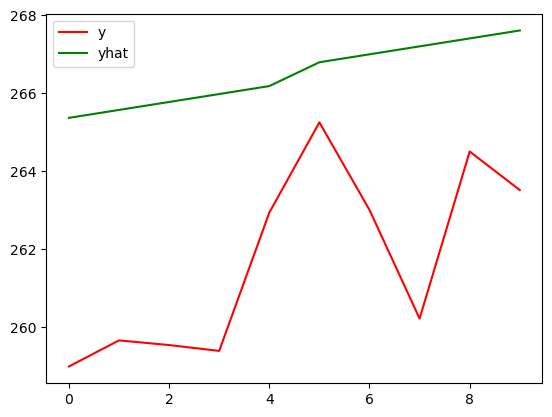

In [11]:
plt.plot(res['y'], color='red', label='y')
plt.plot(res['yhat'], color='green', label='yhat')
plt.legend()
plt.show()

Прогоним то же самое для Яндекса

16:10:11 - cmdstanpy - INFO - Chain [1] start processing
16:10:13 - cmdstanpy - INFO - Chain [1] done processing


Absolute value:
RMSE: 159.99017832623412
MAE: 154.2191896974503

In percent:
RMSE: 6.527919927137174%
MAE: 6.292452024899436%
Uplift: 2.0130691466814714e-06


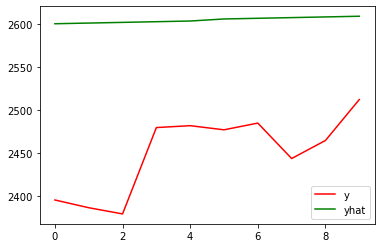

In [108]:
res = predict_price('YNDX', '2022-01-01', '2023-10-01')

res = res[['ds', 'yhat']]
res['ds'] = res['ds'].dt.date

df_test = Ticker('YNDX').candles(date='2023-09-30', till_date='2023-11-02', period='D')
df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

df_test = df_test[['ds', 'y']]
df_test.head()

df_test['ds'] = df_test['ds'].dt.date
df_test.head()

res = res.merge(df_test, on='ds')
res['diff'] = res['y'] - res['yhat']
rmse = np.sqrt(np.square(res['diff']).mean())
mae = np.abs(res['diff']).mean()
AVG = res['y'].mean()
uplift = uplift_metric(res)
print(f"Absolute value:\nRMSE: {rmse}\nMAE: {mae}\n\nIn percent:\nRMSE: {rmse/AVG*100}%\nMAE: {mae/AVG*100}%\nUplift: {uplift}")
plt.plot(res['y'], color='red', label='y')
plt.plot(res['yhat'], color='green', label='yhat')
plt.legend()
plt.show()

23:07:13 - cmdstanpy - INFO - Chain [1] start processing
23:07:14 - cmdstanpy - INFO - Chain [1] done processing
23:07:15 - cmdstanpy - INFO - Chain [1] start processing
23:07:16 - cmdstanpy - INFO - Chain [1] done processing
23:07:17 - cmdstanpy - INFO - Chain [1] start processing
23:07:17 - cmdstanpy - INFO - Chain [1] done processing
23:07:19 - cmdstanpy - INFO - Chain [1] start processing
23:07:20 - cmdstanpy - INFO - Chain [1] done processing
23:07:21 - cmdstanpy - INFO - Chain [1] start processing
23:07:22 - cmdstanpy - INFO - Chain [1] done processing
23:07:23 - cmdstanpy - INFO - Chain [1] start processing
23:07:24 - cmdstanpy - INFO - Chain [1] done processing
23:07:26 - cmdstanpy - INFO - Chain [1] start processing
23:07:26 - cmdstanpy - INFO - Chain [1] done processing
23:07:28 - cmdstanpy - INFO - Chain [1] start processing
23:07:28 - cmdstanpy - INFO - Chain [1] done processing
23:07:30 - cmdstanpy - INFO - Chain [1] start processing
23:07:30 - cmdstanpy - INFO - Chain [1]

RMSE: 9.358308410960232


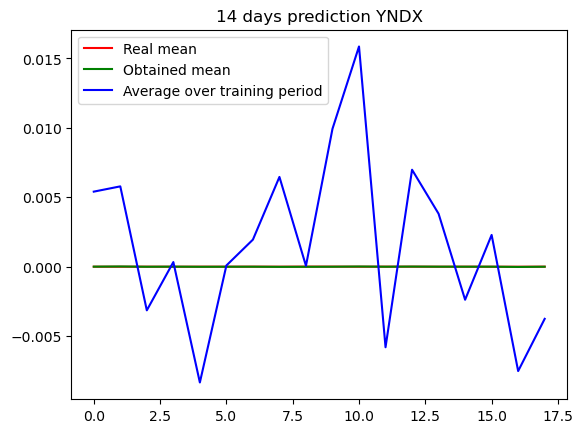

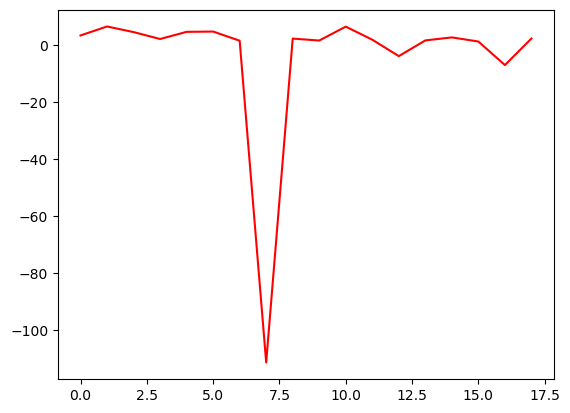

In [113]:
realmeans = []
obtainedmeans = []
metrica = []
stupid_means = []

for i in range(1,10):
    
    startdate = '2023-0' + str(i)+'-01'
    enddate = '2023-0' + str(i)+'-14'

    res = predict_price('YNDX', startdate, enddate,period_forecast = 14, freq_train='10m')

    res = res[['ds', 'yhat']]
    res['ds'] = res['ds'].dt.date

    df_test = Ticker('YNDX').candles(date='2023-01-01', till_date='2023-11-02', period='D')
    df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

    df_test = df_test[['ds', 'y']]
    df_test.head()

    df_test['ds'] = df_test['ds'].dt.date
    df_test.head()

    res = res.merge(df_test, on='ds')
    res['diff'] = res['y'] - res['yhat']
    rmse = np.sqrt(np.square(res['diff']).mean())
    mae = np.abs(res['diff']).mean()
    AVG = res['y'].mean()
    uplift = uplift_metric(res)
    coef = coeff(res)
    realmeans.append(coef[0])
    obtainedmeans.append(coef[1])
    metrica.append(uplift)
#     print(f"Absolute value:\nRMSE: {rmse}\nMAE: {mae}\n\nIn percent:\nRMSE: {rmse/AVG*100}%\nMAE: {mae/AVG*100}%\nUplift: {uplift}")
#     print('Real mean:', coef[0],"\nObtained:", coef[1])

    df_test = Ticker('YNDX').candles(date=startdate, till_date=enddate, period='D')
    df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

    df_test = df_test[['y']]
    #print("Stupid mean:", df_test['y'].pct_change().mean())
    stupid_means.append(df_test['y'].pct_change().mean())
    
    """ 
    """
    if i<9:
        startdate = '2023-0' + str(i)+'-14'
        enddate = '2023-0' + str(i+1)+'-01'
    else:
        startdate = '2023-0' + str(i)+'-14'
        enddate = '2023-' + str(i+1)+'-01'

    res = predict_price('YNDX', startdate, enddate,period_forecast = 14, freq_train='10m')

    res = res[['ds', 'yhat']]
    res['ds'] = res['ds'].dt.date

    df_test = Ticker('YNDX').candles(date='2023-01-01', till_date='2023-11-02', period='D')
    df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

    df_test = df_test[['ds', 'y']]
    df_test.head()

    df_test['ds'] = df_test['ds'].dt.date
    df_test.head()

    res = res.merge(df_test, on='ds')
    res['diff'] = res['y'] - res['yhat']
    rmse = np.sqrt(np.square(res['diff']).mean())
    mae = np.abs(res['diff']).mean()
    AVG = res['y'].mean()
    uplift = uplift_metric(res)
    coef = coeff(res)
    realmeans.append(coef[0])
    obtainedmeans.append(coef[1])
    metrica.append(uplift)
#     print(f"Absolute value:\nRMSE: {rmse}\nMAE: {mae}\n\nIn percent:\nRMSE: {rmse/AVG*100}%\nMAE: {mae/AVG*100}%\nUplift: {uplift}")
#     print('Real mean:', coef[0],"\nObtained:", coef[1])

    df_test = Ticker('YNDX').candles(date=startdate, till_date=enddate, period='D')
    df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

    df_test = df_test[['y']]
    #print("Stupid mean:", df_test['y'].pct_change().mean())
    stupid_means.append(df_test['y'].pct_change().mean())

# plt.plot(res['y'], color='red', label='y')
# plt.plot(res['yhat'], color='green', label='yhat')
# plt.legend()
# plt.show()

# plt.plot(df_test['y'])
# plt.show()
realmeans = np.array(realmeans)
obtainedmeans = np.array(obtainedmeans)
rmse = np.sqrt(np.square(realmeans- obtainedmeans).mean())*1e6
print('RMSE:',rmse)

plt.figure()
plt.title('14 days prediction YNDX')
plt.plot(realmeans, color = 'red', label = 'Real mean')
plt.plot(obtainedmeans, color = 'green', label = 'Obtained mean')
plt.plot(stupid_means, color = 'blue', label = 'Average over training period')
plt.legend()
plt.show()

plt.figure()
plt.plot(metrica, color = 'red', label = 'uplift')
plt.show()

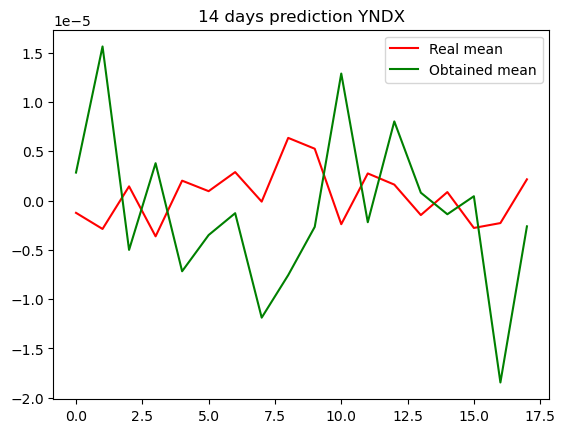

In [114]:
plt.figure()
plt.title('14 days prediction YNDX')
plt.plot(realmeans, color = 'red', label = 'Real mean')
plt.plot(obtainedmeans, color = 'green', label = 'Obtained mean')
#plt.plot(stupid_means, color = 'blue', label = 'Average over training period')
plt.legend()
plt.show()

# plt.figure()
# plt.plot(metrica, color = 'red', label = 'uplift')
# plt.show()

23:07:51 - cmdstanpy - INFO - Chain [1] start processing
23:07:52 - cmdstanpy - INFO - Chain [1] done processing
23:07:54 - cmdstanpy - INFO - Chain [1] start processing
23:07:55 - cmdstanpy - INFO - Chain [1] done processing
23:07:57 - cmdstanpy - INFO - Chain [1] start processing
23:07:57 - cmdstanpy - INFO - Chain [1] done processing
23:07:59 - cmdstanpy - INFO - Chain [1] start processing
23:08:00 - cmdstanpy - INFO - Chain [1] done processing
23:08:01 - cmdstanpy - INFO - Chain [1] start processing
23:08:02 - cmdstanpy - INFO - Chain [1] done processing
23:08:04 - cmdstanpy - INFO - Chain [1] start processing
23:08:05 - cmdstanpy - INFO - Chain [1] done processing
23:08:06 - cmdstanpy - INFO - Chain [1] start processing
23:08:07 - cmdstanpy - INFO - Chain [1] done processing
23:08:09 - cmdstanpy - INFO - Chain [1] start processing
23:08:10 - cmdstanpy - INFO - Chain [1] done processing
23:08:12 - cmdstanpy - INFO - Chain [1] start processing
23:08:13 - cmdstanpy - INFO - Chain [1]

RMSE: 4.3199431832036375


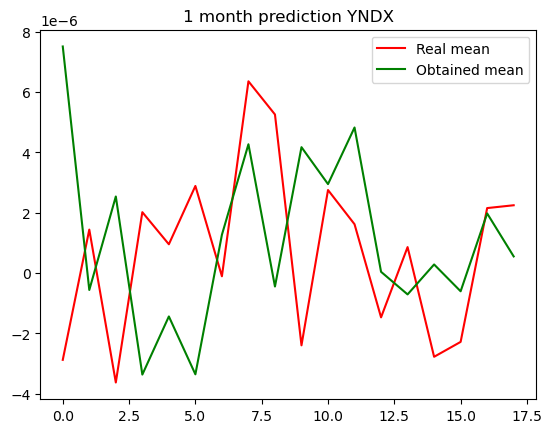

In [115]:
realmeans = []
obtainedmeans = []
metrica = []
stupid_means = []

for i in range(1,10):
    
    if i<9:
        startdate = '2023-0' + str(i)+'-01'
        enddate = '2023-0' + str(i+1)+'-01'
    else:
        startdate = '2023-0' + str(i)+'-01'
        enddate = '2023-' + str(i+1)+'-01'

    res = predict_price('YNDX', startdate, enddate,period_forecast = 14, freq_train='10m')

    res = res[['ds', 'yhat']]
    res['ds'] = res['ds'].dt.date

    df_test = Ticker('YNDX').candles(date='2023-01-01', till_date='2023-11-02', period='D')
    df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

    df_test = df_test[['ds', 'y']]
    df_test.head()

    df_test['ds'] = df_test['ds'].dt.date
    df_test.head()

    res = res.merge(df_test, on='ds')
    res['diff'] = res['y'] - res['yhat']
    rmse = np.sqrt(np.square(res['diff']).mean())
    mae = np.abs(res['diff']).mean()
    AVG = res['y'].mean()
    uplift = uplift_metric(res)
    coef = coeff(res)
    realmeans.append(coef[0])
    obtainedmeans.append(coef[1])
    metrica.append(uplift)
#     print(f"Absolute value:\nRMSE: {rmse}\nMAE: {mae}\n\nIn percent:\nRMSE: {rmse/AVG*100}%\nMAE: {mae/AVG*100}%\nUplift: {uplift}")
#     print('Real mean:', coef[0],"\nObtained:", coef[1])

    df_test = Ticker('YNDX').candles(date=startdate, till_date=enddate, period='D')
    df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

    df_test = df_test[['y']]
    #print("Stupid mean:", df_test['y'].pct_change().mean())
    stupid_means.append(df_test['y'].pct_change().mean())
    
    """ 
    """
    if i<9:
        startdate = '2023-0' + str(i)+'-14'
        enddate = '2023-0' + str(i+1)+'-14'
    else:
        startdate = '2023-0' + str(i)+'-14'
        enddate = '2023-' + str(i+1)+'-14'

    res = predict_price('YNDX', startdate, enddate,period_forecast = 14, freq_train='10m')

    res = res[['ds', 'yhat']]
    res['ds'] = res['ds'].dt.date

    df_test = Ticker('YNDX').candles(date='2023-01-01', till_date='2023-11-02', period='D')
    df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

    df_test = df_test[['ds', 'y']]
    df_test.head()

    df_test['ds'] = df_test['ds'].dt.date
    df_test.head()

    res = res.merge(df_test, on='ds')
    res['diff'] = res['y'] - res['yhat']
    rmse = np.sqrt(np.square(res['diff']).mean())
    mae = np.abs(res['diff']).mean()
    AVG = res['y'].mean()
    uplift = uplift_metric(res)
    coef = coeff(res)
    realmeans.append(coef[0])
    obtainedmeans.append(coef[1])
    metrica.append(uplift)
#     print(f"Absolute value:\nRMSE: {rmse}\nMAE: {mae}\n\nIn percent:\nRMSE: {rmse/AVG*100}%\nMAE: {mae/AVG*100}%\nUplift: {uplift}")
#     print('Real mean:', coef[0],"\nObtained:", coef[1])

    df_test = Ticker('YNDX').candles(date=startdate, till_date=enddate, period='D')
    df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

    df_test = df_test[['y']]
    #print("Stupid mean:", df_test['y'].pct_change().mean())
    stupid_means.append(df_test['y'].pct_change().mean())

# plt.plot(res['y'], color='red', label='y')
# plt.plot(res['yhat'], color='green', label='yhat')
# plt.legend()
# plt.show()

# plt.plot(df_test['y'])
# plt.show()
realmeans = np.array(realmeans)
obtainedmeans = np.array(obtainedmeans)
rmse = np.sqrt(np.square(realmeans- obtainedmeans).mean())*1e6
print('RMSE:',rmse)

plt.figure()
plt.title('1 month prediction YNDX')
plt.plot(realmeans, color = 'red', label = 'Real mean')
plt.plot(obtainedmeans, color = 'green', label = 'Obtained mean')
#plt.plot(stupid_means, color = 'blue', label = 'Average over training period')
plt.legend()
plt.show()

# plt.figure()
# plt.plot(metrica, color = 'red', label = 'uplift')
# plt.show()

23:15:32 - cmdstanpy - INFO - Chain [1] start processing
23:15:34 - cmdstanpy - INFO - Chain [1] done processing
23:15:36 - cmdstanpy - INFO - Chain [1] start processing
23:15:37 - cmdstanpy - INFO - Chain [1] done processing
23:15:39 - cmdstanpy - INFO - Chain [1] start processing
23:15:40 - cmdstanpy - INFO - Chain [1] done processing
23:15:42 - cmdstanpy - INFO - Chain [1] start processing
23:15:43 - cmdstanpy - INFO - Chain [1] done processing
23:15:45 - cmdstanpy - INFO - Chain [1] start processing
23:15:47 - cmdstanpy - INFO - Chain [1] done processing
23:15:48 - cmdstanpy - INFO - Chain [1] start processing
23:15:50 - cmdstanpy - INFO - Chain [1] done processing
23:15:52 - cmdstanpy - INFO - Chain [1] start processing
23:15:53 - cmdstanpy - INFO - Chain [1] done processing
23:15:56 - cmdstanpy - INFO - Chain [1] start processing
23:15:57 - cmdstanpy - INFO - Chain [1] done processing
23:15:59 - cmdstanpy - INFO - Chain [1] start processing
23:16:01 - cmdstanpy - INFO - Chain [1]

RMSE: 3.6420042630118865


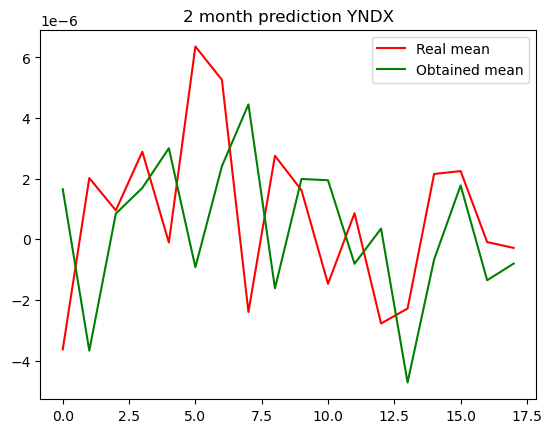

In [119]:
realmeans = []
obtainedmeans = []
metrica = []
stupid_means = []

for i in range(1,10):
    
    if i<8:
        startdate = '2023-0' + str(i)+'-01'
        enddate = '2023-0' + str(i+2)+'-01'
    else:
        startdate = '2023-0' + str(i)+'-01'
        enddate = '2023-' + str(i+2)+'-01'

    res = predict_price('YNDX', startdate, enddate,period_forecast = 14, freq_train='10m')

    res = res[['ds', 'yhat']]
    res['ds'] = res['ds'].dt.date

    df_test = Ticker('YNDX').candles(date='2023-01-01', till_date='2023-12-02', period='D')
    df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

    df_test = df_test[['ds', 'y']]
    df_test.head()

    df_test['ds'] = df_test['ds'].dt.date
    df_test.head()

    res = res.merge(df_test, on='ds')
    res['diff'] = res['y'] - res['yhat']
    rmse = np.sqrt(np.square(res['diff']).mean())
    mae = np.abs(res['diff']).mean()
    AVG = res['y'].mean()
    uplift = uplift_metric(res)
    coef = coeff(res)
    realmeans.append(coef[0])
    obtainedmeans.append(coef[1])
    metrica.append(uplift)
#     print(f"Absolute value:\nRMSE: {rmse}\nMAE: {mae}\n\nIn percent:\nRMSE: {rmse/AVG*100}%\nMAE: {mae/AVG*100}%\nUplift: {uplift}")
#     print('Real mean:', coef[0],"\nObtained:", coef[1])

    df_test = Ticker('YNDX').candles(date=startdate, till_date=enddate, period='D')
    df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

    df_test = df_test[['y']]
    #print("Stupid mean:", df_test['y'].pct_change().mean())
    stupid_means.append(df_test['y'].pct_change().mean())
    
    """ 
    """
    if i<8:
        startdate = '2023-0' + str(i)+'-14'
        enddate = '2023-0' + str(i+2)+'-14'
    else:
        startdate = '2023-0' + str(i)+'-14'
        enddate = '2023-' + str(i+2)+'-14'

    res = predict_price('YNDX', startdate, enddate,period_forecast = 14, freq_train='10m')

    res = res[['ds', 'yhat']]
    res['ds'] = res['ds'].dt.date

    df_test = Ticker('YNDX').candles(date='2023-01-01', till_date='2023-12-02', period='D')
    df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

    df_test = df_test[['ds', 'y']]
    df_test.head()

    df_test['ds'] = df_test['ds'].dt.date
    df_test.head()

    res = res.merge(df_test, on='ds')
    res['diff'] = res['y'] - res['yhat']
    rmse = np.sqrt(np.square(res['diff']).mean())
    mae = np.abs(res['diff']).mean()
    AVG = res['y'].mean()
    uplift = uplift_metric(res)
    coef = coeff(res)
    realmeans.append(coef[0])
    obtainedmeans.append(coef[1])
    metrica.append(uplift)
#     print(f"Absolute value:\nRMSE: {rmse}\nMAE: {mae}\n\nIn percent:\nRMSE: {rmse/AVG*100}%\nMAE: {mae/AVG*100}%\nUplift: {uplift}")
#     print('Real mean:', coef[0],"\nObtained:", coef[1])

    df_test = Ticker('YNDX').candles(date=startdate, till_date=enddate, period='D')
    df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

    df_test = df_test[['y']]
    #print("Stupid mean:", df_test['y'].pct_change().mean())
    stupid_means.append(df_test['y'].pct_change().mean())

# plt.plot(res['y'], color='red', label='y')
# plt.plot(res['yhat'], color='green', label='yhat')
# plt.legend()
# plt.show()

# plt.plot(df_test['y'])
# plt.show()
realmeans = np.array(realmeans)
obtainedmeans = np.array(obtainedmeans)
rmse = np.sqrt(np.square(realmeans- obtainedmeans).mean())*1e6
print('RMSE:',rmse)

plt.figure()
plt.title('2 month prediction YNDX')
plt.plot(realmeans, color = 'red', label = 'Real mean')
plt.plot(obtainedmeans, color = 'green', label = 'Obtained mean')
#plt.plot(stupid_means, color = 'blue', label = 'Average over training period')
plt.legend()
plt.show()

# plt.figure()
# plt.plot(metrica, color = 'red', label = 'uplift')
# plt.show()

23:24:12 - cmdstanpy - INFO - Chain [1] start processing
23:24:15 - cmdstanpy - INFO - Chain [1] done processing
23:24:17 - cmdstanpy - INFO - Chain [1] start processing
23:24:19 - cmdstanpy - INFO - Chain [1] done processing
23:24:22 - cmdstanpy - INFO - Chain [1] start processing
23:24:24 - cmdstanpy - INFO - Chain [1] done processing
23:24:26 - cmdstanpy - INFO - Chain [1] start processing
23:24:28 - cmdstanpy - INFO - Chain [1] done processing
23:24:31 - cmdstanpy - INFO - Chain [1] start processing
23:24:32 - cmdstanpy - INFO - Chain [1] done processing
23:24:35 - cmdstanpy - INFO - Chain [1] start processing
23:24:36 - cmdstanpy - INFO - Chain [1] done processing
23:24:39 - cmdstanpy - INFO - Chain [1] start processing
23:24:41 - cmdstanpy - INFO - Chain [1] done processing
23:24:43 - cmdstanpy - INFO - Chain [1] start processing
23:24:46 - cmdstanpy - INFO - Chain [1] done processing
23:24:48 - cmdstanpy - INFO - Chain [1] start processing
23:24:51 - cmdstanpy - INFO - Chain [1]

RMSE: 3.4589144125102593


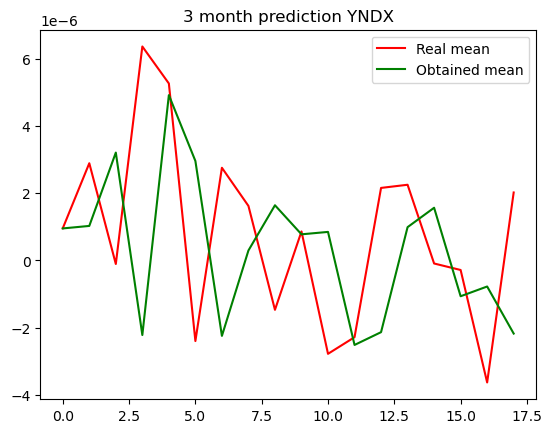

In [124]:
realmeans = []
obtainedmeans = []
metrica = []
stupid_means = []

for i in range(1,10):
    
    
    if i<7:
        startdate = '2023-0' + str(i)+'-01'
        enddate = '2023-0' + str(i+3)+'-01'
    elif i<9:
        startdate = '2023-0' + str(i)+'-01'
        enddate = '2023-' + str(i+3)+'-01'
    else:
        startdate = '2022-12-01'
        enddate = '2023-03-01'

    res = predict_price('YNDX', startdate, enddate,period_forecast = 14, freq_train='10m')

    res = res[['ds', 'yhat']]
    res['ds'] = res['ds'].dt.date

    df_test = Ticker('YNDX').candles(date='2023-01-01', till_date='2023-12-02', period='D')
    df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

    df_test = df_test[['ds', 'y']]
    df_test.head()

    df_test['ds'] = df_test['ds'].dt.date
    df_test.head()

    res = res.merge(df_test, on='ds')
    res['diff'] = res['y'] - res['yhat']
    rmse = np.sqrt(np.square(res['diff']).mean())
    mae = np.abs(res['diff']).mean()
    AVG = res['y'].mean()
    uplift = uplift_metric(res)
    coef = coeff(res)
    realmeans.append(coef[0])
    obtainedmeans.append(coef[1])
    metrica.append(uplift)
#     print(f"Absolute value:\nRMSE: {rmse}\nMAE: {mae}\n\nIn percent:\nRMSE: {rmse/AVG*100}%\nMAE: {mae/AVG*100}%\nUplift: {uplift}")
#     print('Real mean:', coef[0],"\nObtained:", coef[1])

    df_test = Ticker('YNDX').candles(date=startdate, till_date=enddate, period='D')
    df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

    df_test = df_test[['y']]
    #print("Stupid mean:", df_test['y'].pct_change().mean())
    stupid_means.append(df_test['y'].pct_change().mean())
    
    """ 
    """
    if i<7:
        startdate = '2023-0' + str(i)+'-14'
        enddate = '2023-0' + str(i+3)+'-14'
    elif i<9:
        startdate = '2023-0' + str(i)+'-14'
        enddate = '2023-' + str(i+3)+'-14'
    else:
        startdate = '2022-12-14'
        enddate = '2023-03-14'

    res = predict_price('YNDX', startdate, enddate,period_forecast = 14, freq_train='10m')

    res = res[['ds', 'yhat']]
    res['ds'] = res['ds'].dt.date

    df_test = Ticker('YNDX').candles(date='2023-01-01', till_date='2023-12-02', period='D')
    df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

    df_test = df_test[['ds', 'y']]
    df_test.head()

    df_test['ds'] = df_test['ds'].dt.date
    df_test.head()

    res = res.merge(df_test, on='ds')
    res['diff'] = res['y'] - res['yhat']
    rmse = np.sqrt(np.square(res['diff']).mean())
    mae = np.abs(res['diff']).mean()
    AVG = res['y'].mean()
    uplift = uplift_metric(res)
    coef = coeff(res)
    realmeans.append(coef[0])
    obtainedmeans.append(coef[1])
    metrica.append(uplift)
#     print(f"Absolute value:\nRMSE: {rmse}\nMAE: {mae}\n\nIn percent:\nRMSE: {rmse/AVG*100}%\nMAE: {mae/AVG*100}%\nUplift: {uplift}")
#     print('Real mean:', coef[0],"\nObtained:", coef[1])

    df_test = Ticker('YNDX').candles(date=startdate, till_date=enddate, period='D')
    df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

    df_test = df_test[['y']]
    #print("Stupid mean:", df_test['y'].pct_change().mean())
    stupid_means.append(df_test['y'].pct_change().mean())

# plt.plot(res['y'], color='red', label='y')
# plt.plot(res['yhat'], color='green', label='yhat')
# plt.legend()
# plt.show()

# plt.plot(df_test['y'])
# plt.show()
realmeans = np.array(realmeans)
obtainedmeans = np.array(obtainedmeans)
rmse = np.sqrt(np.square(realmeans- obtainedmeans).mean())*1e6
print('RMSE:',rmse)

plt.figure()
plt.title('3 month prediction YNDX')
plt.plot(realmeans, color = 'red', label = 'Real mean')
plt.plot(obtainedmeans, color = 'green', label = 'Obtained mean')
#plt.plot(stupid_means, color = 'blue', label = 'Average over training period')
plt.legend()
plt.show()

# plt.figure()
# plt.plot(metrica, color = 'red', label = 'uplift')
# plt.show()

10:32:12 - cmdstanpy - INFO - Chain [1] start processing
10:32:15 - cmdstanpy - INFO - Chain [1] done processing
10:35:33 - cmdstanpy - INFO - Chain [1] start processing
10:35:36 - cmdstanpy - INFO - Chain [1] done processing
10:36:11 - cmdstanpy - INFO - Chain [1] start processing
10:36:14 - cmdstanpy - INFO - Chain [1] done processing
10:36:20 - cmdstanpy - INFO - Chain [1] start processing
10:36:23 - cmdstanpy - INFO - Chain [1] done processing
10:36:26 - cmdstanpy - INFO - Chain [1] start processing
10:36:28 - cmdstanpy - INFO - Chain [1] done processing
10:39:50 - cmdstanpy - INFO - Chain [1] start processing
10:39:52 - cmdstanpy - INFO - Chain [1] done processing
10:40:06 - cmdstanpy - INFO - Chain [1] start processing
10:40:08 - cmdstanpy - INFO - Chain [1] done processing
10:42:14 - cmdstanpy - INFO - Chain [1] start processing
10:42:16 - cmdstanpy - INFO - Chain [1] done processing
10:43:07 - cmdstanpy - INFO - Chain [1] start processing
10:43:10 - cmdstanpy - INFO - Chain [1]

RMSE: 3.0200825450290076


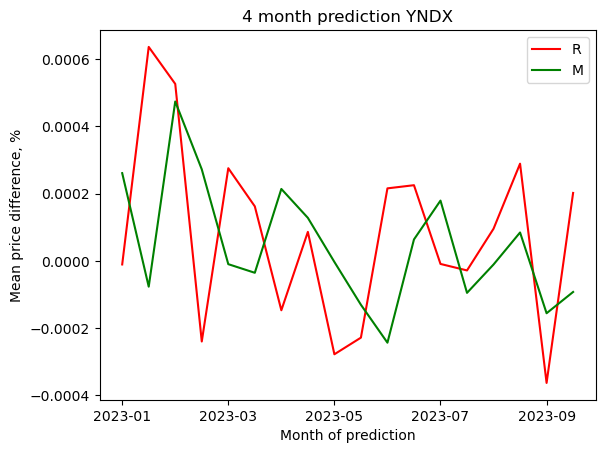

In [134]:
realmeans = []
obtainedmeans = []
metrica = []
stupid_means = []

for i in range(1,10):
    
    if i<6:
        startdate = '2023-0' + str(i)+'-01'
        enddate = '2023-0' + str(i+4)+'-01'
    elif i<8:
        startdate = '2023-0' + str(i)+'-01'
        enddate = '2023-' + str(i+4)+'-01'
    elif i<9:
        startdate = '2022-12-01'
        enddate = '2023-04-01'
    elif i<10:
        startdate = '2022-11-01'
        enddate = '2023-03-01'

    res = predict_price('YNDX', startdate, enddate,period_forecast = 14, freq_train='10m')

    res = res[['ds', 'yhat']]
    res['ds'] = res['ds'].dt.date

    df_test = Ticker('YNDX').candles(date='2023-01-01', till_date='2023-12-02', period='D')
    df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

    df_test = df_test[['ds', 'y']]
    df_test.head()

    df_test['ds'] = df_test['ds'].dt.date
    df_test.head()

    res = res.merge(df_test, on='ds')
    res['diff'] = res['y'] - res['yhat']
    rmse = np.sqrt(np.square(res['diff']).mean())
    mae = np.abs(res['diff']).mean()
    AVG = res['y'].mean()
    uplift = uplift_metric(res)
    coef = coeff(res)
    realmeans.append(coef[0])
    obtainedmeans.append(coef[1])
    metrica.append(uplift)
#     print(f"Absolute value:\nRMSE: {rmse}\nMAE: {mae}\n\nIn percent:\nRMSE: {rmse/AVG*100}%\nMAE: {mae/AVG*100}%\nUplift: {uplift}")
#     print('Real mean:', coef[0],"\nObtained:", coef[1])

    df_test = Ticker('YNDX').candles(date=startdate, till_date=enddate, period='D')
    df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

    df_test = df_test[['y']]
    #print("Stupid mean:", df_test['y'].pct_change().mean())
    stupid_means.append(df_test['y'].pct_change().mean())
    
    """ 
    """
    if i<6:
        startdate = '2023-0' + str(i)+'-14'
        enddate = '2023-0' + str(i+4)+'-14'
    elif i<8:
        startdate = '2023-0' + str(i)+'-14'
        enddate = '2023-' + str(i+4)+'-14'
    elif i<9:
        startdate = '2022-12-14'
        enddate = '2023-04-14'
    elif i<10:
        startdate = '2022-11-14'
        enddate = '2023-03-14'

    res = predict_price('YNDX', startdate, enddate,period_forecast = 14, freq_train='10m')

    res = res[['ds', 'yhat']]
    res['ds'] = res['ds'].dt.date

    df_test = Ticker('YNDX').candles(date='2023-01-01', till_date='2023-12-02', period='D')
    df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

    df_test = df_test[['ds', 'y']]
    df_test.head()

    df_test['ds'] = df_test['ds'].dt.date
    df_test.head()

    res = res.merge(df_test, on='ds')
    res['diff'] = res['y'] - res['yhat']
    rmse = np.sqrt(np.square(res['diff']).mean())
    mae = np.abs(res['diff']).mean()
    AVG = res['y'].mean()
    uplift = uplift_metric(res)
    coef = coeff(res)
    realmeans.append(coef[0])
    obtainedmeans.append(coef[1])
    metrica.append(uplift)
#     print(f"Absolute value:\nRMSE: {rmse}\nMAE: {mae}\n\nIn percent:\nRMSE: {rmse/AVG*100}%\nMAE: {mae/AVG*100}%\nUplift: {uplift}")
#     print('Real mean:', coef[0],"\nObtained:", coef[1])

    df_test = Ticker('YNDX').candles(date=startdate, till_date=enddate, period='D')
    df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

    df_test = df_test[['y']]
    #print("Stupid mean:", df_test['y'].pct_change().mean())
    stupid_means.append(df_test['y'].pct_change().mean())

# plt.plot(res['y'], color='red', label='y')
# plt.plot(res['yhat'], color='green', label='yhat')
# plt.legend()
# plt.show()

# plt.plot(df_test['y'])
# plt.show()
realmeans = np.array(realmeans)
obtainedmeans = np.array(obtainedmeans)
rmse = np.sqrt(np.square(realmeans- obtainedmeans).mean())*1e6
print('RMSE:',rmse)

plt.figure()
plt.title('4 month prediction YNDX')
plt.plot(realmeans*100, color = 'red', label = 'Real mean (next 14 days)')
plt.plot(obtainedmeans*100, color = 'green', label = 'Obtained mean (next 14 days)')
plt.xticks([0, 4, 8, 12, 16], ['2023-01', '2023-03', '2023-05', '2023-07', '2023-09'])
plt.xlabel('Month of prediction')
plt.ylabel('Mean price difference, %')
#plt.plot(stupid_means, color = 'blue', label = 'Average over training period')
plt.legend('RMSE = 3.019e-4')
plt.show()

# plt.figure()
# plt.plot(metrica, color = 'red', label = 'uplift')
# plt.show()

In [ ]:
plt.figure()
plt.title('4 month prediction YNDX')
plt.plot(realmeans*100, color = 'red', label = 'Real mean (next 14 days)')
plt.plot(obtainedmeans*100, color = 'green', label = 'Obtained mean (next 14 days)')
plt.xticks([0, 4, 8, 12, 16], ['2023-01', '2023-03', '2023-05', '2023-07', '2023-09'])
plt.xlabel('Month of prediction')
plt.ylabel('Mean price difference, %')
#plt.plot(stupid_means, color = 'blue', label = 'Average over training period')
plt.legend('RMSE = 3.019e-4')
plt.show()

23:30:16 - cmdstanpy - INFO - Chain [1] start processing
23:30:19 - cmdstanpy - INFO - Chain [1] done processing
23:30:22 - cmdstanpy - INFO - Chain [1] start processing
23:30:26 - cmdstanpy - INFO - Chain [1] done processing
23:30:29 - cmdstanpy - INFO - Chain [1] start processing
23:30:31 - cmdstanpy - INFO - Chain [1] done processing
23:30:35 - cmdstanpy - INFO - Chain [1] start processing
23:30:38 - cmdstanpy - INFO - Chain [1] done processing
23:30:42 - cmdstanpy - INFO - Chain [1] start processing
23:30:45 - cmdstanpy - INFO - Chain [1] done processing
23:30:48 - cmdstanpy - INFO - Chain [1] start processing
23:30:52 - cmdstanpy - INFO - Chain [1] done processing
23:30:55 - cmdstanpy - INFO - Chain [1] start processing
23:30:59 - cmdstanpy - INFO - Chain [1] done processing
23:31:02 - cmdstanpy - INFO - Chain [1] start processing
23:31:06 - cmdstanpy - INFO - Chain [1] done processing
23:31:09 - cmdstanpy - INFO - Chain [1] start processing
23:31:13 - cmdstanpy - INFO - Chain [1]

RMSE: 3.0962927825960724


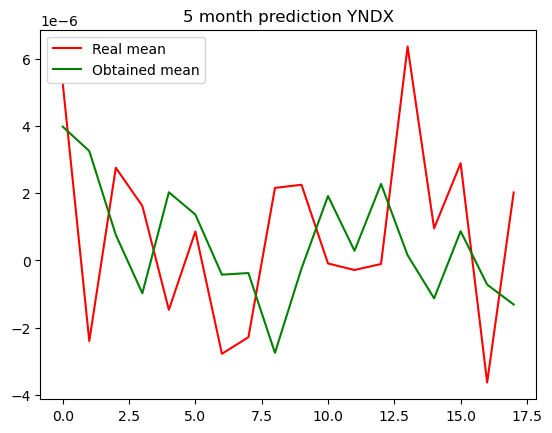

In [127]:
realmeans = []
obtainedmeans = []
metrica = []
stupid_means = []

for i in range(1,10):
    
    if i<5:
        startdate = '2023-0' + str(i)+'-01'
        enddate = '2023-0' + str(i+5)+'-01'
    elif i<7:
        startdate = '2023-0' + str(i)+'-01'
        enddate = '2023-' + str(i+5)+'-01'
    elif i<8:
        startdate = '2022-12-01'
        enddate = '2023-05-01'
    elif i<9:
        startdate = '2022-11-01'
        enddate = '2023-04-01'
    elif i<10:
        startdate = '2022-10-01'
        enddate = '2023-03-01'

    res = predict_price('YNDX', startdate, enddate,period_forecast = 14, freq_train='10m')

    res = res[['ds', 'yhat']]
    res['ds'] = res['ds'].dt.date

    df_test = Ticker('YNDX').candles(date='2023-01-01', till_date='2023-12-02', period='D')
    df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

    df_test = df_test[['ds', 'y']]
    df_test.head()

    df_test['ds'] = df_test['ds'].dt.date
    df_test.head()

    res = res.merge(df_test, on='ds')
    res['diff'] = res['y'] - res['yhat']
    rmse = np.sqrt(np.square(res['diff']).mean())
    mae = np.abs(res['diff']).mean()
    AVG = res['y'].mean()
    uplift = uplift_metric(res)
    coef = coeff(res)
    realmeans.append(coef[0])
    obtainedmeans.append(coef[1])
    metrica.append(uplift)
#     print(f"Absolute value:\nRMSE: {rmse}\nMAE: {mae}\n\nIn percent:\nRMSE: {rmse/AVG*100}%\nMAE: {mae/AVG*100}%\nUplift: {uplift}")
#     print('Real mean:', coef[0],"\nObtained:", coef[1])

    df_test = Ticker('YNDX').candles(date=startdate, till_date=enddate, period='D')
    df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

    df_test = df_test[['y']]
    #print("Stupid mean:", df_test['y'].pct_change().mean())
    stupid_means.append(df_test['y'].pct_change().mean())
    
    """ 
    """
    if i<5:
        startdate = '2023-0' + str(i)+'-14'
        enddate = '2023-0' + str(i+5)+'-14'
    elif i<7:
        startdate = '2023-0' + str(i)+'-14'
        enddate = '2023-' + str(i+5)+'-14'
    elif i<8:
        startdate = '2022-12-14'
        enddate = '2023-05-14'
    elif i<9:
        startdate = '2022-11-14'
        enddate = '2023-04-14'
    elif i<10:
        startdate = '2022-10-14'
        enddate = '2023-03-14'

    res = predict_price('YNDX', startdate, enddate,period_forecast = 14, freq_train='10m')

    res = res[['ds', 'yhat']]
    res['ds'] = res['ds'].dt.date

    df_test = Ticker('YNDX').candles(date='2023-01-01', till_date='2023-12-02', period='D')
    df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

    df_test = df_test[['ds', 'y']]
    df_test.head()

    df_test['ds'] = df_test['ds'].dt.date
    df_test.head()

    res = res.merge(df_test, on='ds')
    res['diff'] = res['y'] - res['yhat']
    rmse = np.sqrt(np.square(res['diff']).mean())
    mae = np.abs(res['diff']).mean()
    AVG = res['y'].mean()
    uplift = uplift_metric(res)
    coef = coeff(res)
    realmeans.append(coef[0])
    obtainedmeans.append(coef[1])
    metrica.append(uplift)
#     print(f"Absolute value:\nRMSE: {rmse}\nMAE: {mae}\n\nIn percent:\nRMSE: {rmse/AVG*100}%\nMAE: {mae/AVG*100}%\nUplift: {uplift}")
#     print('Real mean:', coef[0],"\nObtained:", coef[1])

    df_test = Ticker('YNDX').candles(date=startdate, till_date=enddate, period='D')
    df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

    df_test = df_test[['y']]
    #print("Stupid mean:", df_test['y'].pct_change().mean())
    stupid_means.append(df_test['y'].pct_change().mean())

# plt.plot(res['y'], color='red', label='y')
# plt.plot(res['yhat'], color='green', label='yhat')
# plt.legend()
# plt.show()

# plt.plot(df_test['y'])
# plt.show()
realmeans = np.array(realmeans)
obtainedmeans = np.array(obtainedmeans)
rmse = np.sqrt(np.square(realmeans- obtainedmeans).mean())*1e6
print('RMSE:',rmse)

plt.figure()
plt.title('5 month prediction YNDX')
plt.plot(realmeans, color = 'red', label = 'Real mean')
plt.plot(obtainedmeans, color = 'green', label = 'Obtained mean')
#plt.plot(stupid_means, color = 'blue', label = 'Average over training period')
plt.legend()
plt.show()

# plt.figure()
# plt.plot(metrica, color = 'red', label = 'uplift')
# plt.show()

23:35:00 - cmdstanpy - INFO - Chain [1] start processing
23:35:04 - cmdstanpy - INFO - Chain [1] done processing
23:35:07 - cmdstanpy - INFO - Chain [1] start processing
23:35:10 - cmdstanpy - INFO - Chain [1] done processing
23:35:14 - cmdstanpy - INFO - Chain [1] start processing
23:35:18 - cmdstanpy - INFO - Chain [1] done processing
23:35:21 - cmdstanpy - INFO - Chain [1] start processing
23:35:26 - cmdstanpy - INFO - Chain [1] done processing
23:35:30 - cmdstanpy - INFO - Chain [1] start processing
23:35:34 - cmdstanpy - INFO - Chain [1] done processing
23:35:37 - cmdstanpy - INFO - Chain [1] start processing
23:35:41 - cmdstanpy - INFO - Chain [1] done processing
23:35:45 - cmdstanpy - INFO - Chain [1] start processing
23:35:49 - cmdstanpy - INFO - Chain [1] done processing
23:35:52 - cmdstanpy - INFO - Chain [1] start processing
23:35:57 - cmdstanpy - INFO - Chain [1] done processing
23:36:01 - cmdstanpy - INFO - Chain [1] start processing
23:36:05 - cmdstanpy - INFO - Chain [1]

RMSE: 3.226524790990604


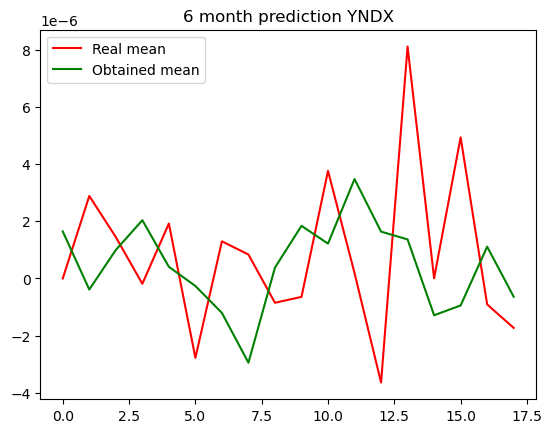

In [130]:
realmeans = []
obtainedmeans = []
metrica = []
stupid_means = []

for i in range(1,10):
    
    if i<4:
        startdate = '2023-0' + str(i)+'-01'
        enddate = '2023-0' + str(i+6)+'-01'
    elif i<6:
        startdate = '2023-0' + str(i)+'-01'
        enddate = '2023-' + str(i+6)+'-01'
    elif i<7:
        startdate = '2022-12-01'
        enddate = '2023-06-01'
    elif i<8:
        startdate = '2022-11-01'
        enddate = '2023-05-01'
    elif i<9:
        startdate = '2022-10-01'
        enddate = '2023-04-01'
    elif i<10:
        startdate = '2022-09-01'
        enddate = '2023-03-01'

    res = predict_price('YNDX', startdate, enddate,period_forecast = 14, freq_train='10m')

    res = res[['ds', 'yhat']]
    res['ds'] = res['ds'].dt.date

    df_test = Ticker('YNDX').candles(date='2023-01-01', till_date='2023-12-02', period='D')
    df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

    df_test = df_test[['ds', 'y']]
    df_test.head()

    df_test['ds'] = df_test['ds'].dt.date
    df_test.head()

    res = res.merge(df_test, on='ds')
    res['diff'] = res['y'] - res['yhat']
    rmse = np.sqrt(np.square(res['diff']).mean())
    mae = np.abs(res['diff']).mean()
    AVG = res['y'].mean()
    uplift = uplift_metric(res)
    coef = coeff(res)
    realmeans.append(coef[0])
    obtainedmeans.append(coef[1])
    metrica.append(uplift)
#     print(f"Absolute value:\nRMSE: {rmse}\nMAE: {mae}\n\nIn percent:\nRMSE: {rmse/AVG*100}%\nMAE: {mae/AVG*100}%\nUplift: {uplift}")
#     print('Real mean:', coef[0],"\nObtained:", coef[1])

    df_test = Ticker('YNDX').candles(date=startdate, till_date=enddate, period='D')
    df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

    df_test = df_test[['y']]
    #print("Stupid mean:", df_test['y'].pct_change().mean())
    stupid_means.append(df_test['y'].pct_change().mean())
    
    """ 
    """
    if i<4:
        startdate = '2023-0' + str(i)+'-14'
        enddate = '2023-0' + str(i+6)+'-14'
    elif i<6:
        startdate = '2023-0' + str(i)+'-14'
        enddate = '2023-' + str(i+6)+'-14'
    elif i<7:
        startdate = '2022-12-14'
        enddate = '2023-06-14'
    elif i<8:
        startdate = '2022-11-14'
        enddate = '2023-05-14'
    elif i<9:
        startdate = '2022-10-14'
        enddate = '2023-04-14'
    elif i<10:
        startdate = '2022-09-14'
        enddate = '2023-03-14'

    res = predict_price('YNDX', startdate, enddate,period_forecast = 14, freq_train='10m')

    res = res[['ds', 'yhat']]
    res['ds'] = res['ds'].dt.date

    df_test = Ticker('YNDX').candles(date='2023-01-01', till_date='2023-12-02', period='D')
    df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

    df_test = df_test[['ds', 'y']]
    df_test.head()

    df_test['ds'] = df_test['ds'].dt.date
    df_test.head()

    res = res.merge(df_test, on='ds')
    res['diff'] = res['y'] - res['yhat']
    rmse = np.sqrt(np.square(res['diff']).mean())
    mae = np.abs(res['diff']).mean()
    AVG = res['y'].mean()
    uplift = uplift_metric(res)
    coef = coeff(res)
    realmeans.append(coef[0])
    obtainedmeans.append(coef[1])
    metrica.append(uplift)
#     print(f"Absolute value:\nRMSE: {rmse}\nMAE: {mae}\n\nIn percent:\nRMSE: {rmse/AVG*100}%\nMAE: {mae/AVG*100}%\nUplift: {uplift}")
#     print('Real mean:', coef[0],"\nObtained:", coef[1])

    df_test = Ticker('YNDX').candles(date=startdate, till_date=enddate, period='D')
    df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

    df_test = df_test[['y']]
    #print("Stupid mean:", df_test['y'].pct_change().mean())
    stupid_means.append(df_test['y'].pct_change().mean())

# plt.plot(res['y'], color='red', label='y')
# plt.plot(res['yhat'], color='green', label='yhat')
# plt.legend()
# plt.show()

# plt.plot(df_test['y'])
# plt.show()
realmeans = np.array(realmeans)
obtainedmeans = np.array(obtainedmeans)
rmse = np.sqrt(np.square(realmeans- obtainedmeans).mean())*1e6
print('RMSE:',rmse)

plt.figure()
plt.title('6 month prediction YNDX')
plt.plot(realmeans, color = 'red', label = 'Real mean')
plt.plot(obtainedmeans, color = 'green', label = 'Obtained mean')
#plt.plot(stupid_means, color = 'blue', label = 'Average over training period')
plt.legend()
plt.show()

# plt.figure()
# plt.plot(metrica, color = 'red', label = 'uplift')
# plt.show()

23:37:17 - cmdstanpy - INFO - Chain [1] start processing
23:37:21 - cmdstanpy - INFO - Chain [1] done processing
23:37:26 - cmdstanpy - INFO - Chain [1] start processing
23:37:31 - cmdstanpy - INFO - Chain [1] done processing
23:37:36 - cmdstanpy - INFO - Chain [1] start processing
23:37:40 - cmdstanpy - INFO - Chain [1] done processing
23:37:44 - cmdstanpy - INFO - Chain [1] start processing
23:37:50 - cmdstanpy - INFO - Chain [1] done processing
23:37:54 - cmdstanpy - INFO - Chain [1] start processing
23:37:58 - cmdstanpy - INFO - Chain [1] done processing
23:38:02 - cmdstanpy - INFO - Chain [1] start processing
23:38:07 - cmdstanpy - INFO - Chain [1] done processing
23:38:11 - cmdstanpy - INFO - Chain [1] start processing
23:38:15 - cmdstanpy - INFO - Chain [1] done processing
23:38:19 - cmdstanpy - INFO - Chain [1] start processing
23:38:25 - cmdstanpy - INFO - Chain [1] done processing
23:38:29 - cmdstanpy - INFO - Chain [1] start processing
23:38:35 - cmdstanpy - INFO - Chain [1]

RMSE: nan


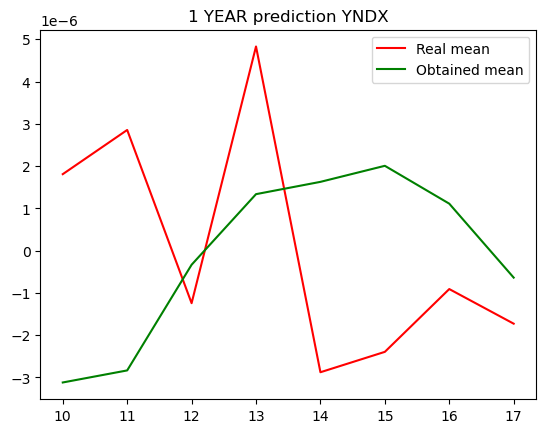

In [131]:
realmeans = []
obtainedmeans = []
metrica = []
stupid_means = []

for i in range(1,10):
    
    startdate = '2022-0' + str(i)+'-01'
    enddate = '2023-0' + str(i)+'-01'


    res = predict_price('YNDX', startdate, enddate,period_forecast = 14, freq_train='10m')

    res = res[['ds', 'yhat']]
    res['ds'] = res['ds'].dt.date

    df_test = Ticker('YNDX').candles(date='2023-01-01', till_date='2023-11-02', period='D')
    df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

    df_test = df_test[['ds', 'y']]
    df_test.head()

    df_test['ds'] = df_test['ds'].dt.date
    df_test.head()

    res = res.merge(df_test, on='ds')
    res['diff'] = res['y'] - res['yhat']
    rmse = np.sqrt(np.square(res['diff']).mean())
    mae = np.abs(res['diff']).mean()
    AVG = res['y'].mean()
    uplift = uplift_metric(res)
    coef = coeff(res)
    realmeans.append(coef[0])
    obtainedmeans.append(coef[1])
    metrica.append(uplift)
#     print(f"Absolute value:\nRMSE: {rmse}\nMAE: {mae}\n\nIn percent:\nRMSE: {rmse/AVG*100}%\nMAE: {mae/AVG*100}%\nUplift: {uplift}")
#     print('Real mean:', coef[0],"\nObtained:", coef[1])

    df_test = Ticker('YNDX').candles(date=startdate, till_date=enddate, period='D')
    df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

    df_test = df_test[['y']]
    #print("Stupid mean:", df_test['y'].pct_change().mean())
    stupid_means.append(df_test['y'].pct_change().mean())
    
    """ 
    """
    startdate = '2022-0' + str(i)+'-14'
    enddate = '2023-0' + str(i)+'-14'

    res = predict_price('YNDX', startdate, enddate,period_forecast = 14, freq_train='10m')

    res = res[['ds', 'yhat']]
    res['ds'] = res['ds'].dt.date

    df_test = Ticker('YNDX').candles(date='2023-01-01', till_date='2023-11-02', period='D')
    df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

    df_test = df_test[['ds', 'y']]
    df_test.head()

    df_test['ds'] = df_test['ds'].dt.date
    df_test.head()

    res = res.merge(df_test, on='ds')
    res['diff'] = res['y'] - res['yhat']
    rmse = np.sqrt(np.square(res['diff']).mean())
    mae = np.abs(res['diff']).mean()
    AVG = res['y'].mean()
    uplift = uplift_metric(res)
    coef = coeff(res)
    realmeans.append(coef[0])
    obtainedmeans.append(coef[1])
    metrica.append(uplift)
#     print(f"Absolute value:\nRMSE: {rmse}\nMAE: {mae}\n\nIn percent:\nRMSE: {rmse/AVG*100}%\nMAE: {mae/AVG*100}%\nUplift: {uplift}")
#     print('Real mean:', coef[0],"\nObtained:", coef[1])

    df_test = Ticker('YNDX').candles(date=startdate, till_date=enddate, period='D')
    df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

    df_test = df_test[['y']]
    #print("Stupid mean:", df_test['y'].pct_change().mean())
    stupid_means.append(df_test['y'].pct_change().mean())

# plt.plot(res['y'], color='red', label='y')
# plt.plot(res['yhat'], color='green', label='yhat')
# plt.legend()
# plt.show()

# plt.plot(df_test['y'])
# plt.show()
realmeans = np.array(realmeans)
obtainedmeans = np.array(obtainedmeans)
rmse = np.sqrt(np.square(realmeans- obtainedmeans).mean())*1e6
print('RMSE:',rmse)

plt.figure()
plt.title('1 YEAR prediction YNDX')
plt.plot(realmeans, color = 'red', label = 'Real mean')
plt.plot(obtainedmeans, color = 'green', label = 'Obtained mean')
#plt.plot(stupid_means, color = 'blue', label = 'Average over training period')
plt.legend()
plt.show()

# plt.figure()
# plt.plot(metrica, color = 'red', label = 'uplift')
# plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


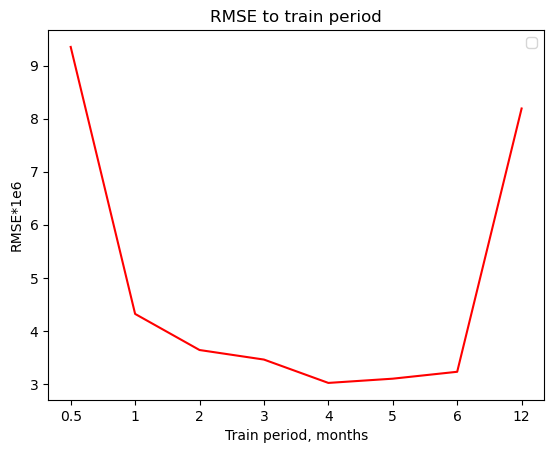

In [135]:
plt.figure()
plt.title('RMSE to train period')
plt.plot([9.35,4.32,3.64,3.46,3.02,3.1,3.23,8.19], color = 'red')
plt.xticks([0, 1,2,3,4,5,6,7], [0.5, 1, 2, 3,4,5,6,12])
plt.xlabel('Train period, months')
plt.ylabel('RMSE*1e6')
#plt.plot(stupid_means, color = 'blue', label = 'Average over training period')
plt.legend()
plt.show()

16:11:44 - cmdstanpy - INFO - Chain [1] start processing
16:11:45 - cmdstanpy - INFO - Chain [1] done processing


Absolute value:
RMSE: 2.123562735986357
MAE: 1.9898208943180293

In percent:
RMSE: 0.8114678731596282%
MAE: 0.7603616797932049%
Uplift: 6.27179911528292e-06


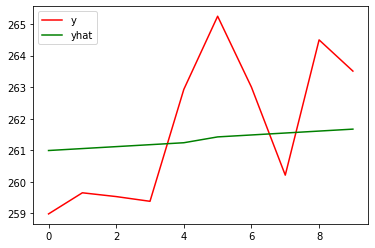

In [111]:
TICKER = 'SBER'

res = predict_price(TICKER, '2022-10-01', '2023-10-01')

res = res[['ds', 'yhat']]
res['ds'] = res['ds'].dt.date

df_test = Ticker(TICKER).candles(date='2023-09-30', till_date='2023-11-02', period='D')
df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

df_test = df_test[['ds', 'y']]
df_test.head()

df_test['ds'] = df_test['ds'].dt.date
df_test.head()

res = res.merge(df_test, on='ds')
res['diff'] = res['y'] - res['yhat']
rmse = np.sqrt(np.square(res['diff']).mean())
mae = np.abs(res['diff']).mean()
AVG = res['y'].mean()
uplift = uplift_metric(res)
print(f"Absolute value:\nRMSE: {rmse}\nMAE: {mae}\n\nIn percent:\nRMSE: {rmse/AVG*100}%\nMAE: {mae/AVG*100}%\nUplift: {uplift}")
plt.plot(res['y'], color='red', label='y')
plt.plot(res['yhat'], color='green', label='yhat')
plt.legend()
plt.show()

16:13:13 - cmdstanpy - INFO - Chain [1] start processing
16:13:14 - cmdstanpy - INFO - Chain [1] done processing


Absolute value:
RMSE: 138.38475934727705
MAE: 110.74326419416721

In percent:
RMSE: 0.8539738802532402%
MAE: 0.683397907991257%
Uplift: 5.033355525873613e-08


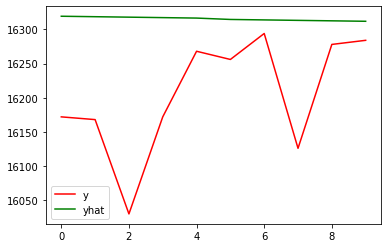

In [112]:
TICKER = 'GMKN'

res = predict_price(TICKER, '2022-10-01', '2023-10-01')

res = res[['ds', 'yhat']]
res['ds'] = res['ds'].dt.date

df_test = Ticker(TICKER).candles(date='2023-09-30', till_date='2023-11-02', period='D')
df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

df_test = df_test[['ds', 'y']]
df_test.head()

df_test['ds'] = df_test['ds'].dt.date
df_test.head()

res = res.merge(df_test, on='ds')
res['diff'] = res['y'] - res['yhat']
rmse = np.sqrt(np.square(res['diff']).mean())
mae = np.abs(res['diff']).mean()
AVG = res['y'].mean()
uplift = uplift_metric(res)
print(f"Absolute value:\nRMSE: {rmse}\nMAE: {mae}\n\nIn percent:\nRMSE: {rmse/AVG*100}%\nMAE: {mae/AVG*100}%\nUplift: {uplift}")
plt.plot(res['y'], color='red', label='y')
plt.plot(res['yhat'], color='green', label='yhat')
plt.legend()
plt.show()

16:19:28 - cmdstanpy - INFO - Chain [1] start processing
16:19:29 - cmdstanpy - INFO - Chain [1] done processing


Absolute value:
RMSE: 88.11373653643948
MAE: 82.58003583376448

In percent:
RMSE: 3.259946152177626%
MAE: 3.055215686508091%
Uplift: -2.363986097621788e-06


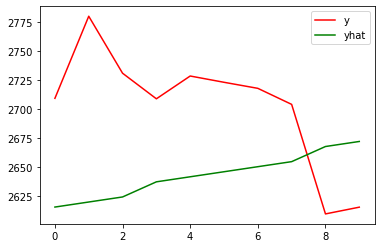

In [120]:
TICKER = 'YNDX'

res = predict_price(TICKER, '2022-08-01', '2023-08-01')

res = res[['ds', 'yhat']]
res['ds'] = res['ds'].dt.date

df_test = Ticker(TICKER).candles(date='2023-07-30', till_date='2023-09-02', period='D')
df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

df_test = df_test[['ds', 'y']]
df_test.head()

df_test['ds'] = df_test['ds'].dt.date
df_test.head()

res = res.merge(df_test, on='ds')
res['diff'] = res['y'] - res['yhat']
rmse = np.sqrt(np.square(res['diff']).mean())
mae = np.abs(res['diff']).mean()
AVG = res['y'].mean()
uplift = uplift_metric(res)
print(f"{TICKER}\nAbsolute value:\nRMSE: {rmse}\nMAE: {mae}\n\nIn percent:\nRMSE: {rmse/AVG*100}%\nMAE: {mae/AVG*100}%\nUplift: {uplift}")
plt.plot(res['y'], color='red', label='y')
plt.plot(res['yhat'], color='green', label='yhat')
plt.legend()
plt.show()

16:19:51 - cmdstanpy - INFO - Chain [1] start processing
16:19:51 - cmdstanpy - INFO - Chain [1] done processing


Absolute value:
RMSE: 14.508361493556492
MAE: 14.098227732033362

In percent:
RMSE: 5.48259108838757%
MAE: 5.32760489597899%
Uplift: -1.6452810081433616e-05


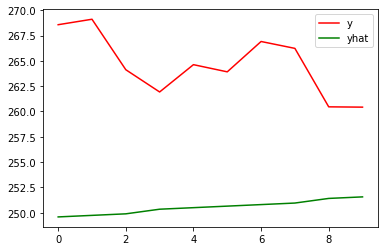

In [121]:
TICKER = 'SBER'

res = predict_price(TICKER, '2022-08-01', '2023-08-01')

res = res[['ds', 'yhat']]
res['ds'] = res['ds'].dt.date

df_test = Ticker(TICKER).candles(date='2023-07-30', till_date='2023-09-02', period='D')
df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

df_test = df_test[['ds', 'y']]
df_test.head()

df_test['ds'] = df_test['ds'].dt.date
df_test.head()

res = res.merge(df_test, on='ds')
res['diff'] = res['y'] - res['yhat']
rmse = np.sqrt(np.square(res['diff']).mean())
mae = np.abs(res['diff']).mean()
AVG = res['y'].mean()
uplift = uplift_metric(res)
print(f"Absolute value:\nRMSE: {rmse}\nMAE: {mae}\n\nIn percent:\nRMSE: {rmse/AVG*100}%\nMAE: {mae/AVG*100}%\nUplift: {uplift}")
plt.plot(res['y'], color='red', label='y')
plt.plot(res['yhat'], color='green', label='yhat')
plt.legend()
plt.show()

16:20:13 - cmdstanpy - INFO - Chain [1] start processing
16:20:14 - cmdstanpy - INFO - Chain [1] done processing


Absolute value:
RMSE: 247.45474602525485
MAE: 212.38034264232664

In percent:
RMSE: 1.5146519398757137%
MAE: 1.2999641475530173%
Uplift: -2.926052126420286e-07


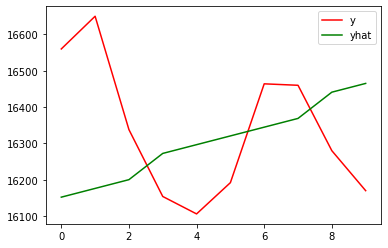

In [122]:
TICKER = 'GMKN'

res = predict_price(TICKER, '2022-08-01', '2023-08-01')

res = res[['ds', 'yhat']]
res['ds'] = res['ds'].dt.date

df_test = Ticker(TICKER).candles(date='2023-07-30', till_date='2023-09-02', period='D')
df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

df_test = df_test[['ds', 'y']]
df_test.head()

df_test['ds'] = df_test['ds'].dt.date
df_test.head()

res = res.merge(df_test, on='ds')
res['diff'] = res['y'] - res['yhat']
rmse = np.sqrt(np.square(res['diff']).mean())
mae = np.abs(res['diff']).mean()
AVG = res['y'].mean()
uplift = uplift_metric(res)
print(f"Absolute value:\nRMSE: {rmse}\nMAE: {mae}\n\nIn percent:\nRMSE: {rmse/AVG*100}%\nMAE: {mae/AVG*100}%\nUplift: {uplift}")
plt.plot(res['y'], color='red', label='y')
plt.plot(res['yhat'], color='green', label='yhat')
plt.legend()
plt.show()

16:21:40 - cmdstanpy - INFO - Chain [1] start processing
16:21:41 - cmdstanpy - INFO - Chain [1] done processing


YNDX
Absolute value:
RMSE: 56.738945023970025
MAE: 41.48402823489164

In percent:
RMSE: 2.315062672856468%
MAE: 1.6926314940425666%
Uplift: 2.746895517904275e-06


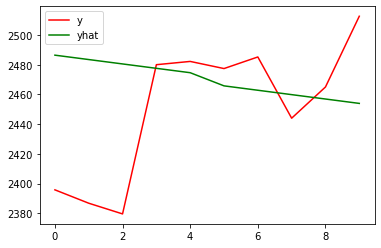

In [123]:
TICKER = 'YNDX'

res = predict_price(TICKER, '2022-10-01', '2023-10-01')

res = res[['ds', 'yhat']]
res['ds'] = res['ds'].dt.date

df_test = Ticker(TICKER).candles(date='2023-09-30', till_date='2023-11-02', period='D')
df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

df_test = df_test[['ds', 'y']]
df_test.head()

df_test['ds'] = df_test['ds'].dt.date
df_test.head()

res = res.merge(df_test, on='ds')
res['diff'] = res['y'] - res['yhat']
rmse = np.sqrt(np.square(res['diff']).mean())
mae = np.abs(res['diff']).mean()
AVG = res['y'].mean()
uplift = uplift_metric(res)
print(f"{TICKER}\nAbsolute value:\nRMSE: {rmse}\nMAE: {mae}\n\nIn percent:\nRMSE: {rmse/AVG*100}%\nMAE: {mae/AVG*100}%\nUplift: {uplift}")
plt.plot(res['y'], color='red', label='y')
plt.plot(res['yhat'], color='green', label='yhat')
plt.legend()
plt.show()

16:22:05 - cmdstanpy - INFO - Chain [1] start processing
16:22:06 - cmdstanpy - INFO - Chain [1] done processing


SBER
Absolute value:
RMSE: 2.123562735986357
MAE: 1.9898208943180293

In percent:
RMSE: 0.8114678731596282%
MAE: 0.7603616797932049%
Uplift: 6.27179911528292e-06


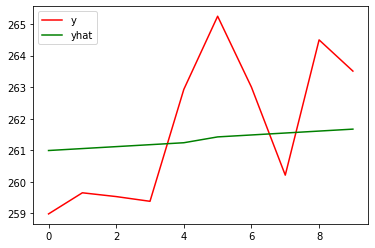

In [124]:
TICKER = 'SBER'

res = predict_price(TICKER, '2022-10-01', '2023-10-01')

res = res[['ds', 'yhat']]
res['ds'] = res['ds'].dt.date

df_test = Ticker(TICKER).candles(date='2023-09-30', till_date='2023-11-02', period='D')
df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

df_test = df_test[['ds', 'y']]
df_test.head()

df_test['ds'] = df_test['ds'].dt.date
df_test.head()

res = res.merge(df_test, on='ds')
res['diff'] = res['y'] - res['yhat']
rmse = np.sqrt(np.square(res['diff']).mean())
mae = np.abs(res['diff']).mean()
AVG = res['y'].mean()
uplift = uplift_metric(res)
print(f"{TICKER}\nAbsolute value:\nRMSE: {rmse}\nMAE: {mae}\n\nIn percent:\nRMSE: {rmse/AVG*100}%\nMAE: {mae/AVG*100}%\nUplift: {uplift}")
plt.plot(res['y'], color='red', label='y')
plt.plot(res['yhat'], color='green', label='yhat')
plt.legend()
plt.show()

16:22:41 - cmdstanpy - INFO - Chain [1] start processing
16:22:42 - cmdstanpy - INFO - Chain [1] done processing


GMKN
Absolute value:
RMSE: 138.38475934727705
MAE: 110.74326419416721

In percent:
RMSE: 0.8539738802532402%
MAE: 0.683397907991257%
Uplift: 5.033355525873613e-08


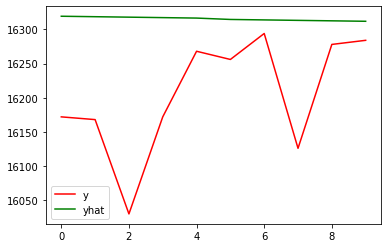

In [126]:
TICKER = 'GMKN'

res = predict_price(TICKER, '2022-10-01', '2023-10-01')

res = res[['ds', 'yhat']]
res['ds'] = res['ds'].dt.date

df_test = Ticker(TICKER).candles(date='2023-09-30', till_date='2023-11-02', period='D')
df_test = df_test.rename(columns = {'close': 'y', 'end': 'ds'})

df_test = df_test[['ds', 'y']]
df_test.head()

df_test['ds'] = df_test['ds'].dt.date
df_test.head()

res = res.merge(df_test, on='ds')
res['diff'] = res['y'] - res['yhat']
rmse = np.sqrt(np.square(res['diff']).mean())
mae = np.abs(res['diff']).mean()
AVG = res['y'].mean()
uplift = uplift_metric(res)
print(f"{TICKER}\nAbsolute value:\nRMSE: {rmse}\nMAE: {mae}\n\nIn percent:\nRMSE: {rmse/AVG*100}%\nMAE: {mae/AVG*100}%\nUplift: {uplift}")
plt.plot(res['y'], color='red', label='y')
plt.plot(res['yhat'], color='green', label='yhat')
plt.legend()
plt.show()